In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller


# Load & preprocessing the data

## Barley

In [4]:
barley_yield = pd.read_csv("data/barley_yield_from_1982.csv", sep=";")
barley_yield

,Unnamed: 0,department,year,yield,area,production
0,82,Ain,1982,3.95008,16065.0,63458.00
1,83,Ain,1983,NaN,14500.0,38400.00
2,84,Ain,1984,4.82258,15500.0,74750.00
3,85,Ain,1985,4.19677,15500.0,65050.00
4,86,Ain,1986,3.59845,12900.0,46420.00
...,...,...,...,...,...,...
3578,11532,Yvelines,2014,7.70000,10180.0,78546.00
3579,11533,Yvelines,2015,8.00000,11420.0,91400.50
3580,11534,Yvelines,2016,NaN,12225.0,64792.50
3581,11535,Yvelines,2017,7.31000,13735.0,100402.85


In [ ]:
barley_yield

## climate data

In [7]:
climate_data = pd.read_parquet("data/climate_data_from_1982.parquet")
climate_data

,scenario,nom_dep,code_dep,time,year,metric,value
0,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,2.762923e+02
0,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,2.750924e+02
0,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,2.764185e+02
0,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,2.788934e+02
0,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,2.788872e+02
...,...,...,...,...,...,...,...
0,ssp5_8_5,Yvelines,78,2050-12-27 12:00:00,2050,precipitation,3.356686e-05
0,ssp5_8_5,Yvelines,78,2050-12-28 12:00:00,2050,precipitation,3.531645e-06
0,ssp5_8_5,Yvelines,78,2050-12-29 12:00:00,2050,precipitation,4.072561e-06
0,ssp5_8_5,Yvelines,78,2050-12-30 12:00:00,2050,precipitation,4.087608e-09


In [8]:
print("Memory before optimization (MB):")
print(climate_data.memory_usage(deep=True).sum() / 1e6)
# Convert categorical columns
optimized_df = climate_data.copy()
categorical_cols = ['scenario', 'nom_dep', 'code_dep', 'metric']
for col in categorical_cols:
    optimized_df[col] = optimized_df[col].astype('category')

# Convert year to int16
optimized_df['year'] = optimized_df['year'].astype('int16')

print("Memory after optimization (MB):")
print(optimized_df.memory_usage(deep=True).sum() / 1e6)


Memory before optimization (MB):
3614.82188
Memory after optimization (MB):
352.053163


In [41]:
optimized_df.dtypes

scenario          category
nom_dep           category
code_dep          category
time        datetime64[ns]
year                 int16
metric            category
value              float32
dtype: object

In [11]:
#extracting metrics
metric_df = optimized_df.pivot(
    index=["scenario", "nom_dep", "code_dep", "time", "year"],
    columns="metric",
    values="value"
).reset_index()
metric_df.columns.name = None
metric_df

,scenario,nom_dep,code_dep,time,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
0,historical,Ain,01,1982-01-01 12:00:00,1982,279.337311,276.292267,3.298677e-05
1,historical,Ain,01,1982-01-02 12:00:00,1982,277.687225,275.092407,1.394672e-04
2,historical,Ain,01,1982-01-03 12:00:00,1982,278.388794,276.418518,9.061195e-05
3,historical,Ain,01,1982-01-04 12:00:00,1982,283.519043,278.893372,5.659108e-05
4,historical,Ain,01,1982-01-05 12:00:00,1982,281.122253,278.887207,2.570244e-04
...,...,...,...,...,...,...,...,...
4583495,ssp5_8_5,Yvelines,78,2050-12-27 12:00:00,2050,275.954895,272.477722,3.356686e-05
4583496,ssp5_8_5,Yvelines,78,2050-12-28 12:00:00,2050,281.925537,279.003143,3.531645e-06
4583497,ssp5_8_5,Yvelines,78,2050-12-29 12:00:00,2050,285.255005,283.358429,4.072561e-06
4583498,ssp5_8_5,Yvelines,78,2050-12-30 12:00:00,2050,284.745300,280.749329,4.087608e-09


## creating dfs based on scenarios

In [15]:
ssp5_8_5 = metric_df[metric_df["scenario"]=="ssp5_8_5"]
ssp2_4_5 = metric_df[metric_df["scenario"]=="ssp2_4_5"]
ssp1_2_6 = metric_df[metric_df["scenario"]=="ssp1_2_6"]
historical = metric_df[metric_df["scenario"]=="historical"]

In [ ]:
datasets_names = ["historical", 'ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']
datasets = [historical, ssp1_2_6, ssp2_4_5, ssp5_8_5]

In [23]:
ssp2_4_5.isna().sum()

scenario                                           0
nom_dep                                            0
code_dep                                           0
time                                               0
year                                               0
daily_maximum_near_surface_air_temperature    105192
near_surface_air_temperature                       0
precipitation                                 105192
dtype: int64

# General descriptive info climate_data

In [37]:
for col in optimized_df.columns:
    print(col, "\n",climate_data[col].unique())

scenario 
 ['historical' 'ssp1_2_6' 'ssp2_4_5' 'ssp5_8_5']
nom_dep 
 ['Ain' 'Aisne' 'Allier' 'Alpes_Maritimes' 'Alpes_de_Haute_Provence'
 'Ardeche' 'Ardennes' 'Ariege' 'Aube' 'Aude' 'Aveyron' 'Bas_Rhin'
 'Bouches_du_Rhone' 'Calvados' 'Cantal' 'Charente' 'Charente_Maritime'
 'Cher' 'Correze' 'Cote_d_Or' 'Cotes_d_Armor' 'Creuse' 'Deux_Sevres'
 'Dordogne' 'Doubs' 'Drome' 'Essonne' 'Eure' 'Eure_et_Loir' 'Finistere'
 'Gard' 'Gers' 'Gironde' 'Haut_Rhin' 'Haute_Garonne' 'Haute_Loire'
 'Haute_Marne' 'Haute_Saone' 'Haute_Savoie' 'Haute_Vienne' 'Hautes_Alpes'
 'Hautes_pyrenees' 'Herault' 'Ille_et_Vilaine' 'Indre' 'Indre_et_Loire'
 'Isere' 'Jura' 'Landes' 'Loir_et_Cher' 'Loire' 'Loire_Atlantique'
 'Loiret' 'Lot' 'Lot_et_Garonne' 'Lozere' 'Maine_et_Loire' 'Manche'
 'Marne' 'Mayenne' 'Meurthe_et_Moselle' 'Meuse' 'Morbihan' 'Moselle'
 'Nievre' 'Nord' 'Oise' 'Orne' 'Pas_de_Calais' 'Puy_de_Dome'
 'Pyrenees_Atlantiques' 'Pyrenees_Orientales' 'Rhone' 'Saone_et_Loire'
 'Sarthe' 'Savoie' 'Seine_Maritime' 

In [43]:
optimized_df.shape

(13540116, 7)

In [45]:
optimized_df.info()

<class 'pandas.DataFrame'>
Index: 13540116 entries, 0 to 0
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   scenario  category      
 1   nom_dep   category      
 2   code_dep  category      
 3   time      datetime64[ns]
 4   year      int16         
 5   metric    category      
 6   value     float32       
dtypes: category(4), datetime64[ns](1), float32(1), int16(1)
memory usage: 335.7 MB


In [47]:
optimized_df.isna().sum()

scenario    0
nom_dep     0
code_dep    0
time        0
year        0
metric      0
value       0
dtype: int64

In [49]:
optimized_df.groupby('metric')['value'].describe()


,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
daily_maximum_near_surface_air_temperature,4478308.0,288.603363,8.324001,2.532118e+02,2.824767e+02,287.805389,294.618103,319.311035
near_surface_air_temperature,4583500.0,283.964661,7.419903,2.455779e+02,2.786087e+02,283.396454,289.544655,307.876160
precipitation,4478308.0,0.000085,0.000172,-2.681981e-23,3.613616e-07,0.000013,0.000092,0.005103


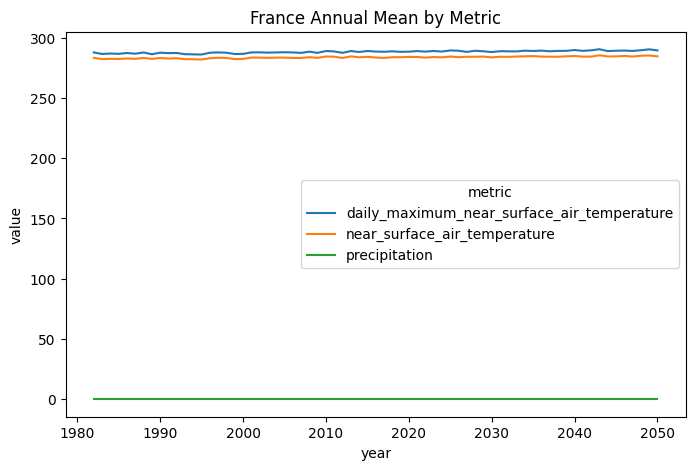

In [64]:
yearly_mean = (
    optimized_df
    .groupby(['year','metric'])['value']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.lineplot(data=yearly_mean, x='year', y='value', hue='metric')
plt.title("France Annual Mean by Metric")
plt.show()


# Scenario comparison

In [189]:
for dataset, name in zip(datasets, datasets_names):
    print("\n", f"***************************************{name}*********************************")
    display(dataset.describe())



 ***************************************historical*********************************


metric,time,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
count,1072717,1.072717e+06,1.072717e+06,1.072717e+06,1.072717e+06
mean,1998-07-02 12:00:00.000000128,1.998000e+03,2.873927e+02,2.830470e+02,9.634846e-05
min,1982-01-01 12:00:00,1.982000e+03,2.532118e+02,2.467508e+02,0.000000e+00
25%,1990-04-02 12:00:00,1.990000e+03,2.814230e+02,2.777937e+02,5.538461e-07
50%,1998-07-02 12:00:00,1.998000e+03,2.868027e+02,2.826508e+02,1.726803e-05
75%,2006-10-01 12:00:00,2.006000e+03,2.933187e+02,2.885720e+02,1.118577e-04
max,2014-12-31 12:00:00,2.014000e+03,3.128563e+02,3.045433e+02,5.103017e-03
std,NaN,9.521677e+00,8.167426e+00,7.339863e+00,1.830550e-04



 ***************************************ssp1_2_6*********************************


metric,time,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
count,1170261,1.170261e+06,1.170261e+06,1.170261e+06,1.170261e+06
mean,2032-12-31 12:00:00.000001024,2.032500e+03,2.887393e+02,2.843083e+02,9.655132e-05
min,2015-01-01 12:00:00,2.015000e+03,2.543313e+02,2.455779e+02,7.425610e-37
25%,2024-01-01 12:00:00,2.024000e+03,2.826010e+02,2.788956e+02,4.243106e-07
50%,2032-12-31 12:00:00,2.032000e+03,2.879462e+02,2.836927e+02,1.477075e-05
75%,2041-12-31 12:00:00,2.041000e+03,2.948043e+02,2.899465e+02,1.079153e-04
max,2050-12-31 12:00:00,2.050000e+03,3.148498e+02,3.071916e+02,4.495658e-03
std,NaN,1.038827e+01,8.306480e+00,7.452561e+00,1.906905e-04



 ***************************************ssp2_4_5*********************************


metric,time,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
count,1170261,1.170261e+06,1.065069e+06,1.170261e+06,1.065069e+06
mean,2032-12-31 12:00:00.000001024,2.032500e+03,2.896243e+02,2.841631e+02,4.601339e-05
min,2015-01-01 12:00:00,2.015000e+03,2.546683e+02,2.469377e+02,-2.681981e-23
25%,2024-01-01 12:00:00,2.024000e+03,2.834166e+02,2.789065e+02,1.103790e-07
50%,2032-12-31 12:00:00,2.032000e+03,2.887150e+02,2.835628e+02,7.878493e-06
75%,2041-12-31 12:00:00,2.041000e+03,2.955768e+02,2.896352e+02,5.149679e-05
max,2050-12-31 12:00:00,2.050000e+03,3.193110e+02,3.061786e+02,2.670596e-03
std,NaN,1.038827e+01,8.327715e+00,7.315490e+00,8.965775e-05



 ***************************************ssp5_8_5*********************************


metric,time,year,daily_maximum_near_surface_air_temperature,near_surface_air_temperature,precipitation
count,1170261,1.170261e+06,1.170261e+06,1.170261e+06,1.170261e+06
mean,2032-12-31 12:00:00.000001024,2.032500e+03,2.886480e+02,2.842638e+02,9.826734e-05
min,2015-01-01 12:00:00,2.015000e+03,2.539505e+02,2.469004e+02,9.308695e-37
25%,2024-01-01 12:00:00,2.024000e+03,2.824359e+02,2.787671e+02,4.828508e-07
50%,2032-12-31 12:00:00,2.032000e+03,2.877937e+02,2.836142e+02,1.645534e-05
75%,2041-12-31 12:00:00,2.041000e+03,2.947283e+02,2.899615e+02,1.118500e-04
max,2050-12-31 12:00:00,2.050000e+03,3.166021e+02,3.078762e+02,4.970227e-03
std,NaN,1.038827e+01,8.341368e+00,7.494798e+00,1.907315e-04


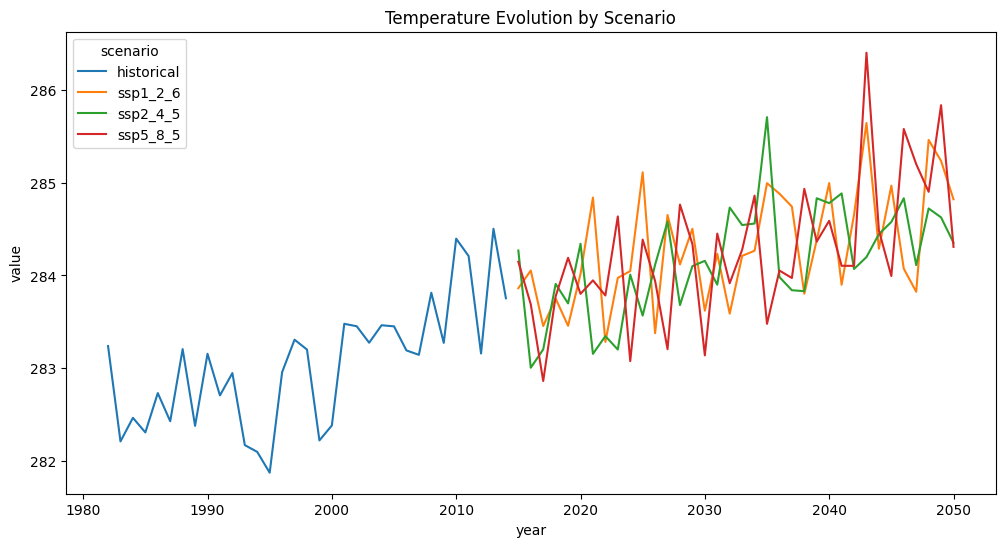

In [68]:
temp_df = optimized_df[optimized_df['metric'] == 'near_surface_air_temperature']

scenario_trend = (
    temp_df
    .groupby(['year','scenario'])['value']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(data=scenario_trend, x='year', y='value', hue='scenario')
plt.title("Temperature Evolution by Scenario")
plt.show()


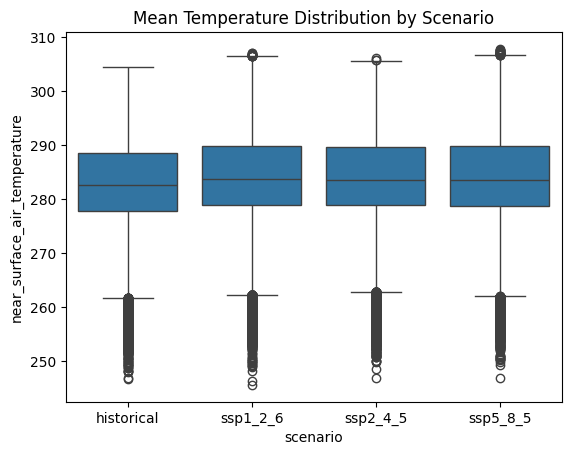

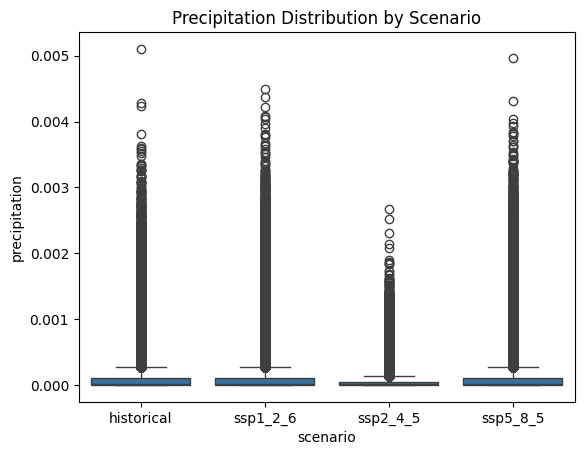

In [125]:

sns.boxplot(data=metric_df, x="scenario", y="near_surface_air_temperature")
plt.title("Mean Temperature Distribution by Scenario")
plt.show()

sns.boxplot(data=metric_df, x="scenario", y="precipitation")
plt.title("Precipitation Distribution by Scenario")
plt.show()


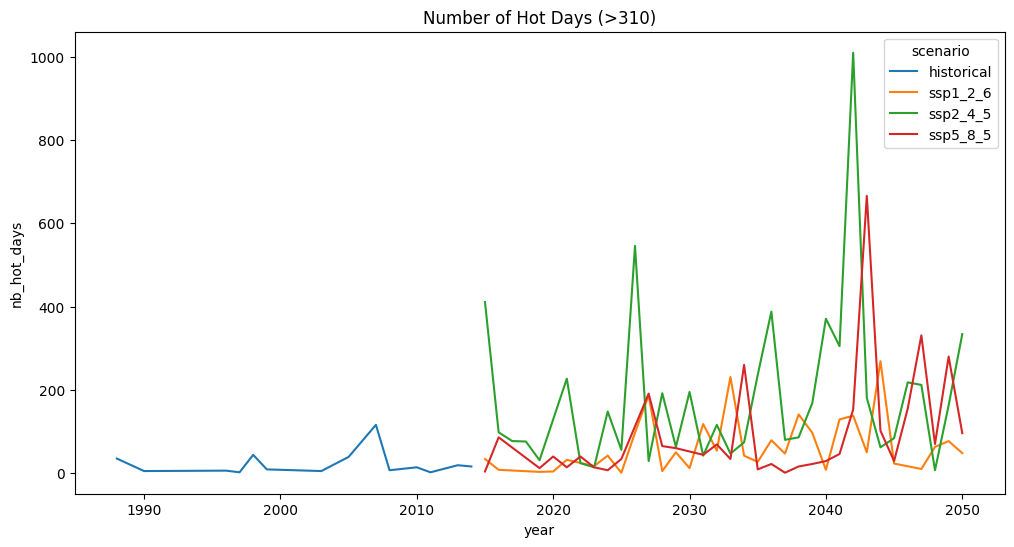

In [145]:
hot_days = metric_df[
    metric_df["daily_maximum_near_surface_air_temperature"] > 310
]

hot_days_count = (
    hot_days.groupby(["scenario", "year"])
    .size()
    .reset_index(name="nb_hot_days")
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=hot_days_count,
    x="year",
    y="nb_hot_days",
    hue="scenario"
)
plt.title("Number of Hot Days (>310)")
plt.show()


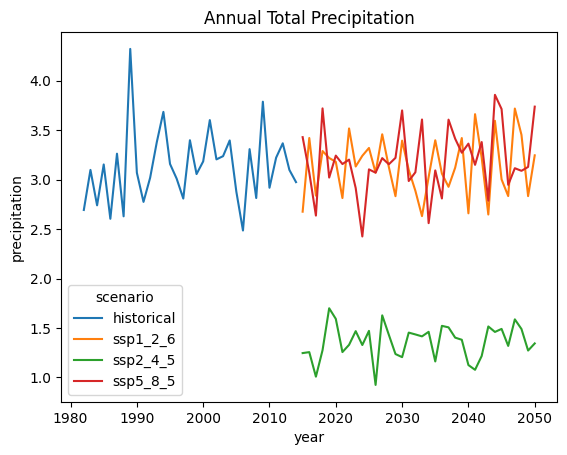

In [147]:
annual_precip = (
    metric_df.groupby(["scenario", "year"])["precipitation"]
    .sum()
    .reset_index()
)

sns.lineplot(
    data=annual_precip,
    x="year",
    y="precipitation",
    hue="scenario"
)
plt.title("Annual Total Precipitation")
plt.show()


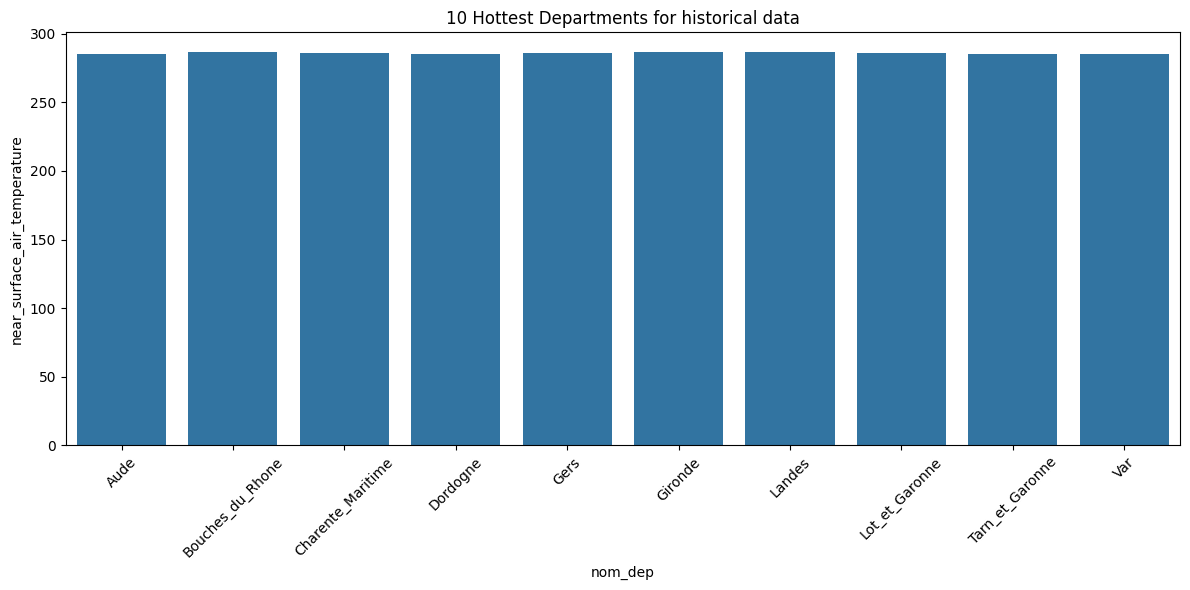

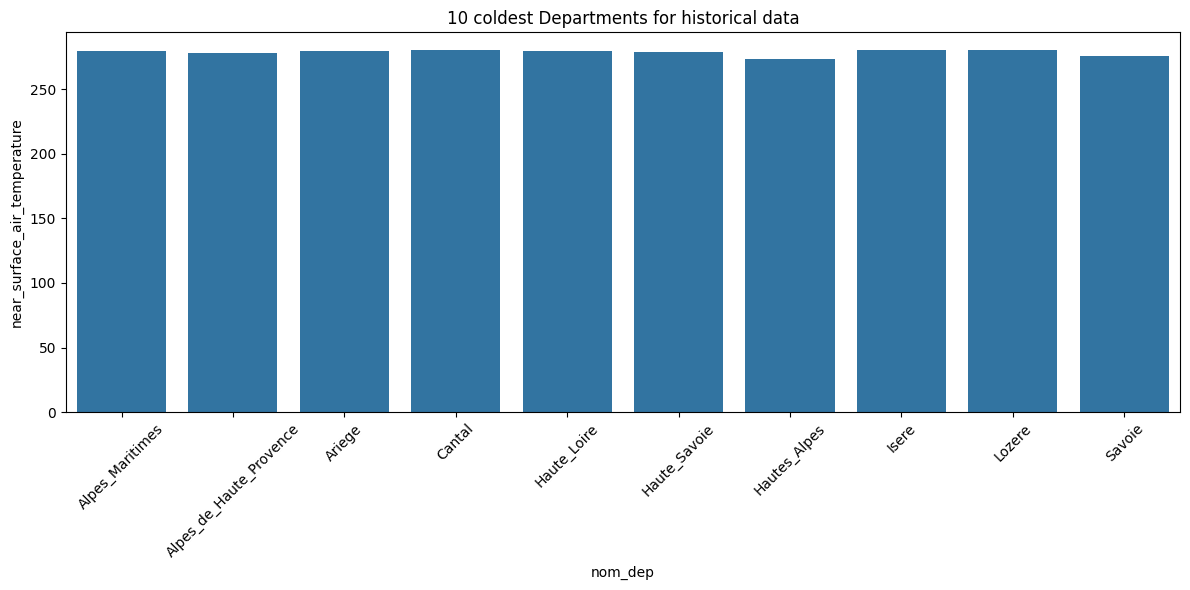

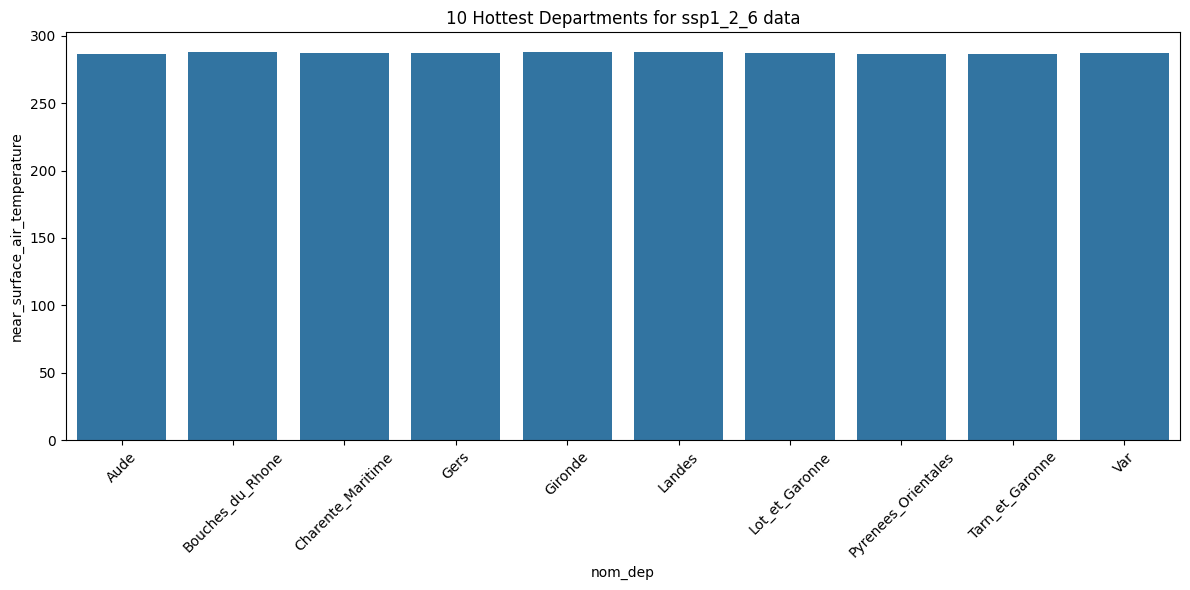

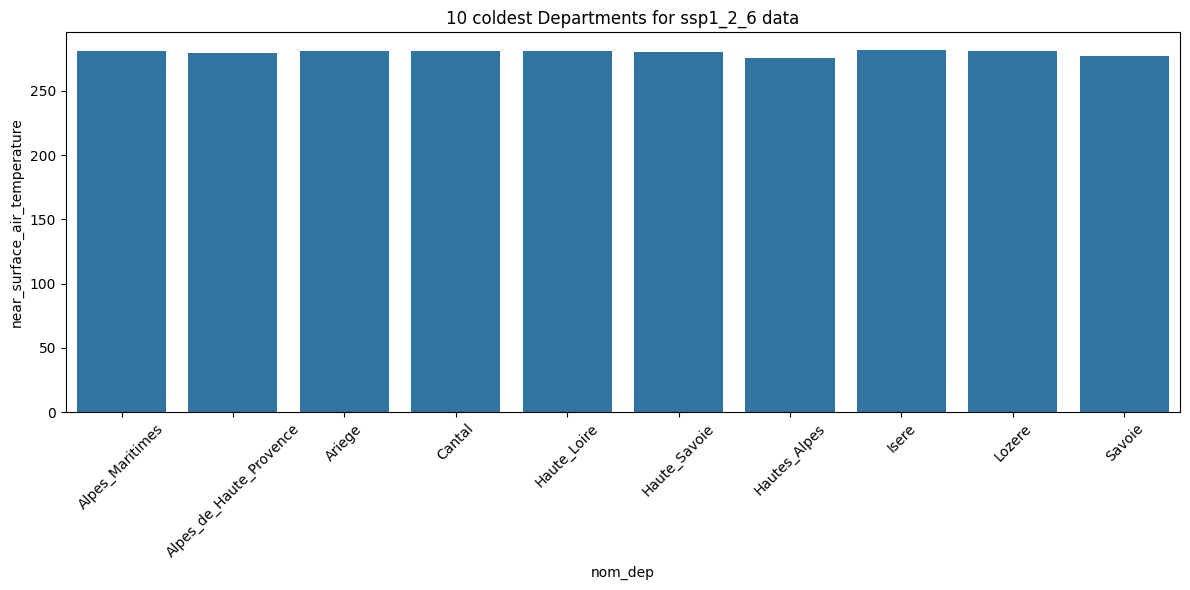

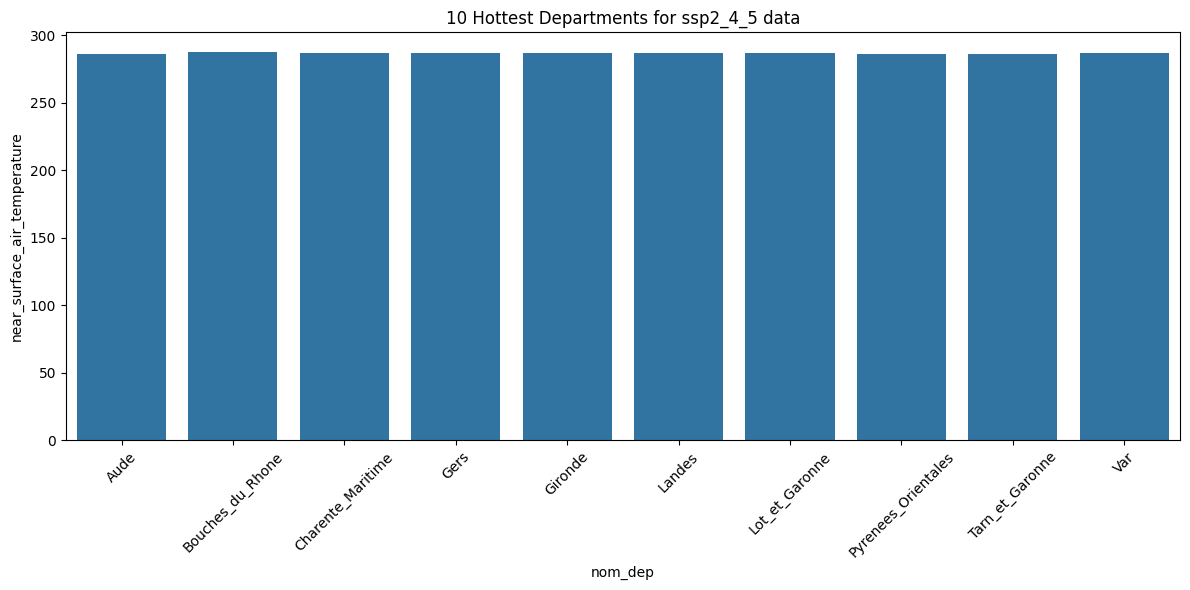

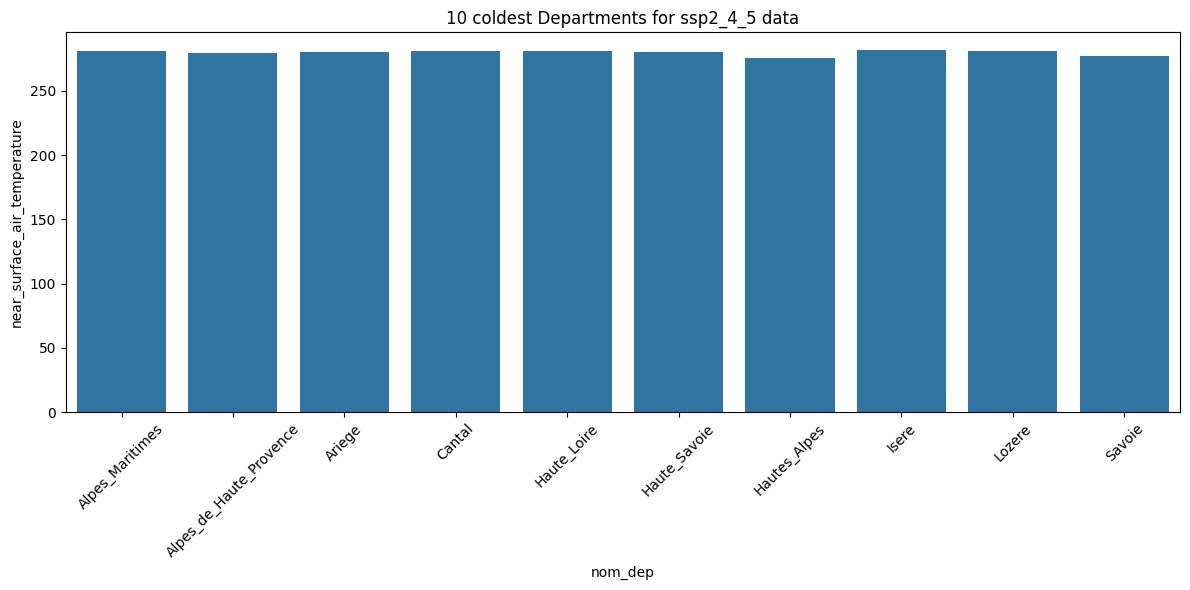

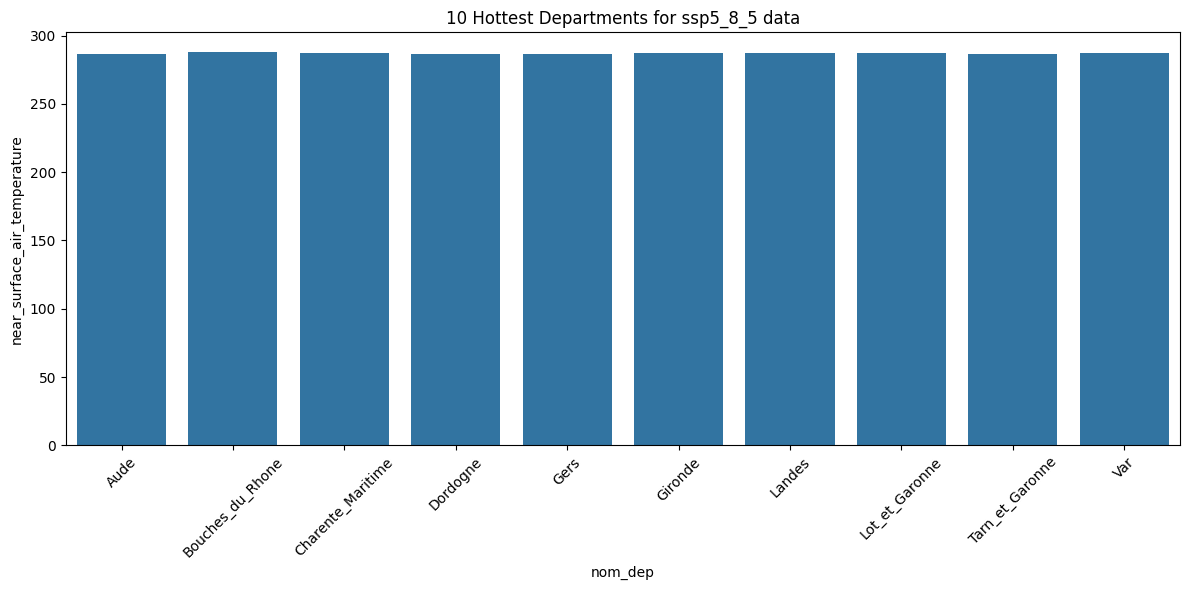

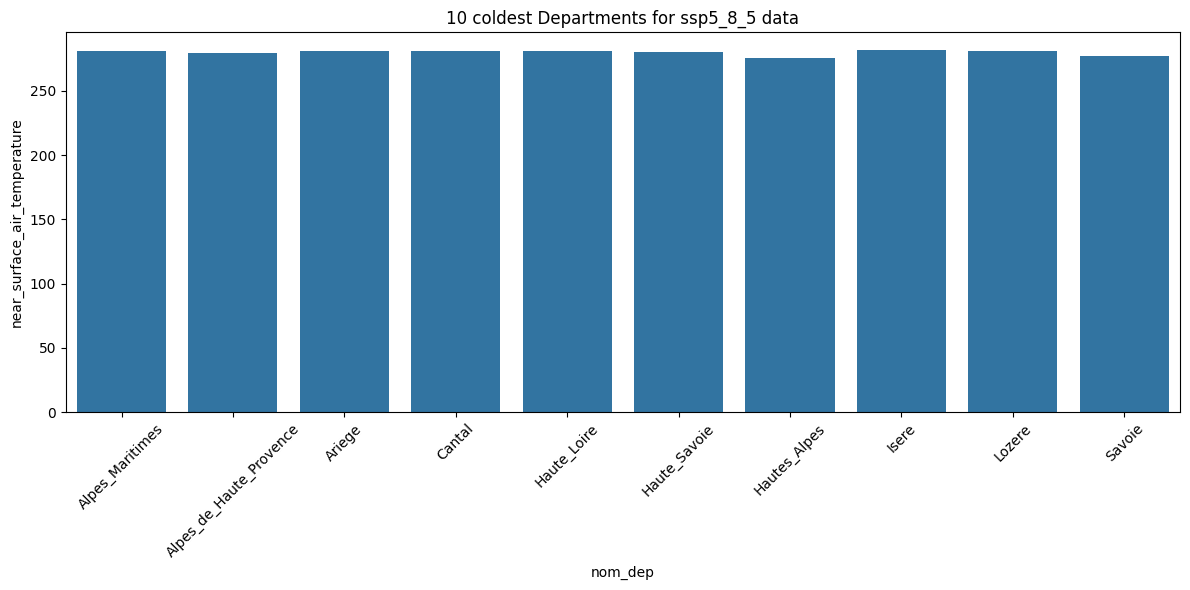

In [209]:
def plot_hottest_and_coldest_per_scenario(scenario, scenario_name, temperature):
    """temperature: hot or cold
        scenario: dataset of the specific scenario
        scenario_name: dataset name of the specific scenario (str)"""
    if temperature == "cold" :
        ascending = True
    if temperature == "hot":
        ascending = False
    if temperature not in ["cold","hot"]:
        return ("Please choose the correct argument for temperature: hot / cold")
    
    dep_summary = (
        scenario.groupby(["nom_dep"])[
            "near_surface_air_temperature"
        ]
        .mean()
        .reset_index()
    )
    
    # 10 hottest per scenario
    top10 = (
        dep_summary
        .sort_values(["near_surface_air_temperature"], ascending=[ ascending])
        .head(10)
    )
    
    top10["nom_dep"] = (
        top10["nom_dep"]
        .cat.remove_unused_categories()
    )
    
    plt.figure(figsize=(12,6))
    
    sns.barplot(
        data=top10,
        x="nom_dep",
        y="near_surface_air_temperature",
    )
    
    plt.xticks(rotation=45)
    if temperature == "cold" :
        plt.title(f"10 coldest Departments for {scenario_name} data")
    if temperature == "hot" :
        plt.title(f"10 Hottest Departments for {scenario_name} data")
    plt.tight_layout()
    plt.show()

for dataset, name in zip(datasets, datasets_names):
    for temperature in ["hot", "cold"]:
        plot_hottest_and_coldest_per_scenario(dataset, name, temperature)


C:\Users\SHAYMAA\Documents\Master\france\HEC\bcg_strategy\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


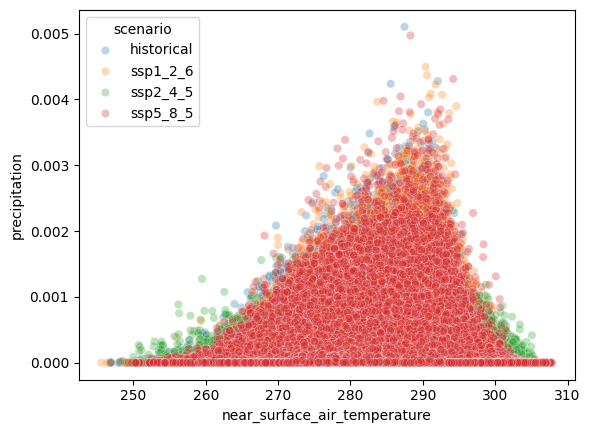

In [223]:
sns.scatterplot(
    data=metric_df,
    x="near_surface_air_temperature",
    y="precipitation",
    hue="scenario",
    alpha=0.3
)
plt.show()
plt.title("Temperature vs Precipitation Relationship")

# Variability analysis in each scenario

In [318]:
from scipy.stats import linregress

def compute_trend(data):
    slope, _, _, _, _ = linregress(data["year"], data["near_surface_air_temperature"])
    return slope

trend = metric_df.groupby("scenario").apply(compute_trend)
print("Linear trend (slope) of near-surface air temperature versus year for each scenario")
print(trend)
print("Each value represents average temperature change per year")
print("All slopes are positive. This means temperature is increasing over time in every scenario. Here we see the slowest warming to the strongest scenario.")

print("\nVariability changes (standard deviation):")
metric_df.groupby("scenario")[
    "near_surface_air_temperature"
].std()

Linear trend (slope) of near-surface air temperature versus year for each scenario
scenario
historical    0.047265
ssp1_2_6      0.031214
ssp2_4_5      0.032735
ssp5_8_5      0.041165
dtype: float64
Each value represents average temperature change per year
All slopes are positive. This means temperature is increasing over time in every scenario. Here we see the slowest warming to the strongest scenario.

Variability changes (standard deviation):


scenario
historical    7.339863
ssp1_2_6      7.452561
ssp2_4_5      7.315490
ssp5_8_5      7.494798
Name: near_surface_air_temperature, dtype: float32

In [324]:
print("Extreme temperatures (e.g., 99th percentile) increase faster than the mean. The hottest days are warming disproportionately compared to average days. This implies Increased variability and More extreme heat events")
metric_df.groupby("scenario")[
    "daily_maximum_near_surface_air_temperature"
].quantile([0.9, 0.99])



Extreme temperatures (e.g., 99th percentile) increase faster than the mean. The hottest days are warming disproportionately compared to average days. This implies Increased variability and More extreme heat events


scenario        
historical  0.90    298.663965
            0.99    305.538850
ssp1_2_6    0.90    300.304688
            0.99    307.249066
ssp2_4_5    0.90    301.193433
            0.99    308.897416
ssp5_8_5    0.90    300.270447
            0.99    307.627722
Name: daily_maximum_near_surface_air_temperature, dtype: float64

In [356]:
print("Skewness for daily max temperature and for surface air temperature:")
display(metric_df.groupby("scenario")[
    "daily_maximum_near_surface_air_temperature"
].skew())

print("\n")
display(metric_df.groupby("scenario")[
    "near_surface_air_temperature"
].skew())

print("Climate change amplifies hot extremes more than it shifts average daily temperature.")

Skewness for daily max temperature and for surface air temperature:


scenario
historical    0.147447
ssp1_2_6      0.197403
ssp2_4_5      0.259345
ssp5_8_5      0.234395
Name: daily_maximum_near_surface_air_temperature, dtype: float32

scenario
historical   -0.014025
ssp1_2_6      0.072995
ssp2_4_5      0.088115
ssp5_8_5      0.110444
Name: near_surface_air_temperature, dtype: float32

Climate change amplifies hot extremes more than it shifts average daily temperature.


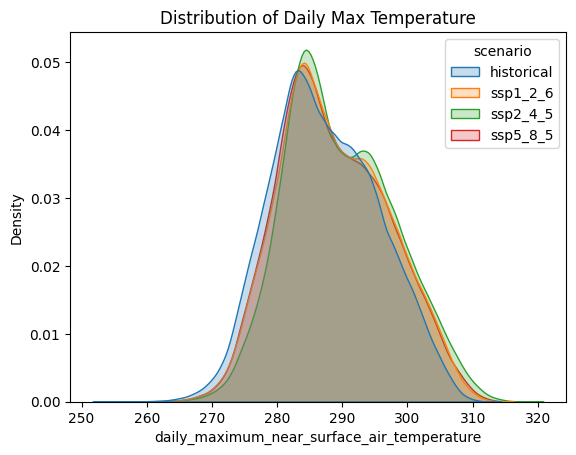

In [329]:

sns.kdeplot(
    data=metric_df,
    x="daily_maximum_near_surface_air_temperature",
    hue="scenario",
    fill=True,
    common_norm=False
)

plt.title("Distribution of Daily Max Temperature")
plt.show()


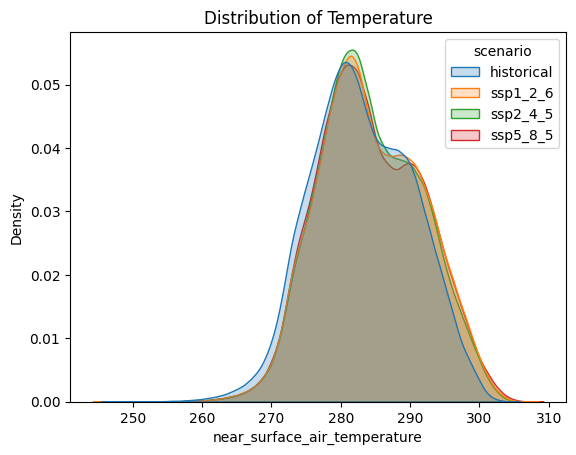

In [361]:

sns.kdeplot(
    data=metric_df,
    x="near_surface_air_temperature",
    hue="scenario",
    fill=True,
    common_norm=False
)

plt.title("Distribution of Temperature")
plt.show()


# Correlation analysis

In [358]:
metric_df.groupby("scenario")[[
    "near_surface_air_temperature",
    "daily_maximum_near_surface_air_temperature",
    "precipitation"
]].corr()


near_surface_air_temperature  \
scenario                                                                              
historical near_surface_air_temperature                                    1.000000   
           daily_maximum_near_surface_air_temperature                      0.979545   
           precipitation                                                  -0.066514   
ssp1_2_6   near_surface_air_temperature                                    1.000000   
           daily_maximum_near_surface_air_temperature                      0.980200   
           precipitation                                                  -0.083393   
ssp2_4_5   near_surface_air_temperature                                    1.000000   
           daily_maximum_near_surface_air_temperature                      0.766216   
           precipitation                                                  -0.117622   
ssp5_8_5   near_surface_air_temperature                                    1.000000   
           daily_maximum_near_surface_air_temperature                      0.980423   
           precipitation                                                  -0.082247   

                                                       daily_maximum_near_surface_air_temperature  \
scenario                                                                                            
historical near_surface_air_temperature                                                  0.979545   
           daily_maximum_near_surface_air_temperature                                    1.000000   
           precipitation                                                                -0.149791   
ssp1_2_6   near_surface_air_temperature                                                  0.980200   
           daily_maximum_near_surface_air_temperature                                    1.000000   
           precipitation                                                                -0.163414   
ssp2_4_5   near_surface_air_temperature                                                  0.766216   
           daily_maximum_near_surface_air_temperature                                    1.000000   
           precipitation                                                                -0.155733   
ssp5_8_5   near_surface_air_temperature                                                  0.980423   
           daily_maximum_near_surface_air_temperature                                    1.000000   
           precipitation                                                                -0.162026   

                                                       precipitation  
scenario                                                              
historical near_surface_air_temperature                    -0.066514  
           daily_maximum_near_surface_air_temperature      -0.149791  
           precipitation                                    1.000000  
ssp1_2_6   near_surface_air_temperature                    -0.083393  
           daily_maximum_near_surface_air_temperature      -0.163414  
           precipitation                                    1.000000  
ssp2_4_5   near_surface_air_temperature                    -0.117622  
           daily_maximum_near_surface_air_temperature      -0.155733  
           precipitation                                    1.000000  
ssp5_8_5   near_surface_air_temperature                    -0.082247  
           daily_maximum_near_surface_air_temperature      -0.162026  
           precipitation                                    1.000000

# Autocorrelation / lag analysis

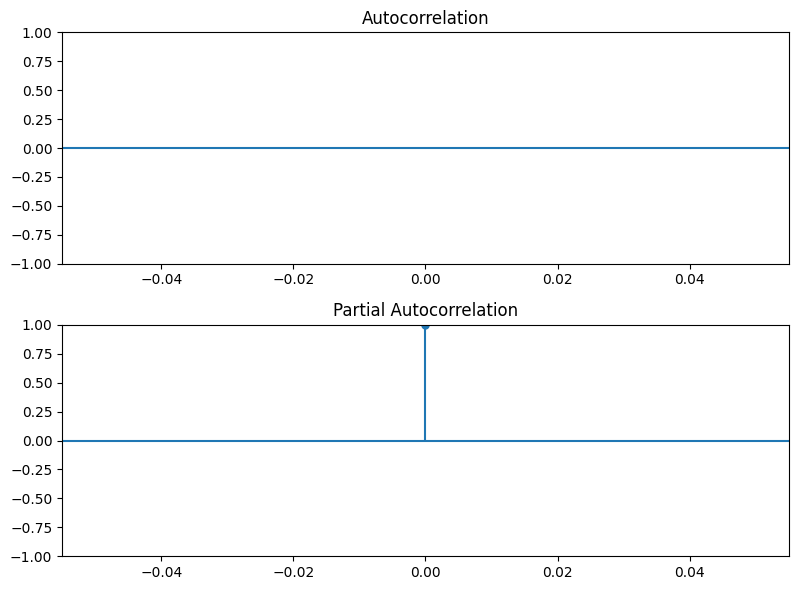

In [276]:

series = (
    barley_yield.iloc[:,1:]
    .sort_values("year")
    ["production"]
)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

plot_acf(series, ax=ax[0])
plot_pacf(series, ax=ax[1])

plt.tight_layout()
plt.show()


In [272]:
barley_yield.columns

Index(['Unnamed: 0', 'department', 'year', 'yield', 'area', 'production'], dtype='str')

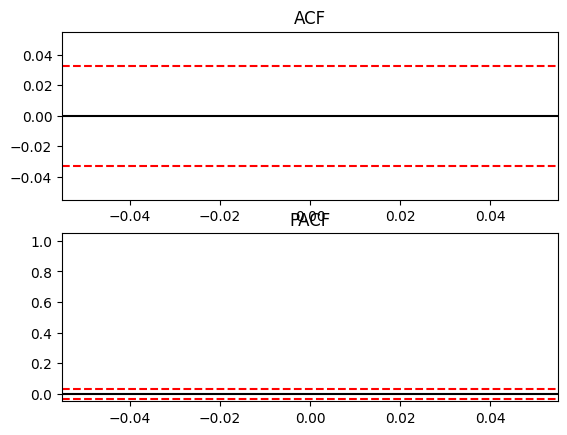

In [279]:
# Plot the ACF and PACF
plt.subplot(211)
plt.plot(acf(barley_yield["production"]))
plt.axhline(0, color='black')
plt.axhline(1.96/np.sqrt(len(barley_yield)), color='red', linestyle='dashed')
plt.axhline(-1.96/np.sqrt(len(barley_yield)), color='red', linestyle='dashed')
plt.title('ACF')

plt.subplot(212)
plt.plot(pacf(barley_yield["production"]))
plt.axhline(0, color='black')
plt.axhline(1.96/np.sqrt(len(barley_yield)), color='red', linestyle='dashed')
plt.axhline(-1.96/np.sqrt(len(barley_yield)), color='red', linestyle='dashed')
plt.title('PACF')

plt.show()

In [287]:

adf_result = adfuller(series.dropna())
print("ADF p-value:", adf_result[1])
#(?)

ADF p-value: 0.0


# Transformations / External data to add

- inflation? / cost indices per matiere primaire
- derived data (check for collinearity though):

          - compute number of hot days (threshold) per year,
          - total duration per heatwave (since will delete time details, can include an aggregate per year) as well as total precipitation during season,
          - consecutive dry days
- any weather data (soil ph, or any in agricultural sources such as ISRIC SoilGrids, European Soil Database, FAO soil maps, National agricultural institutes)
- lag features or decay
- feature transformation:
  
          - Normalize per area (eg divide precipitation per area or so and keep that)

- finir EDA
- set up la pipeline

      -clean la data (pivoter (fait), separer les test split sur les predictions (date threshold), enlever les 8 departements dans barley qui ne sont pas present dnas le 245
      -faire les features (
- model dvp